In [1]:
import torch
from torchvision import datasets, transforms
from siren import Sine

In [2]:
batch_size = 1
transform=transforms.ToTensor()
# dataset_train = datasets.MNIST('data', train=True, download=True,transform=transform)
dataset_train = datasets.Caltech101('data', download=True, transform=transform)
dataloader_train = torch.utils.data.DataLoader(dataset_train,batch_size=batch_size,shuffle=True,num_workers=4)

Files already downloaded and verified


In [12]:
im, label = next(iter(dataloader_train))

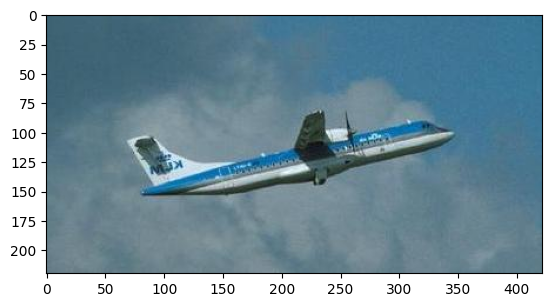

In [13]:
# plot image using maplotlib
import matplotlib.pyplot as plt
plt.imshow(im[0].permute(1, 2, 0))

In [28]:
im.shape

torch.Size([1, 3, 220, 422])

In [124]:
def siren_init(m):
    ''' 
    initialization following the Siren paper: https://arxiv.org/pdf/2006.09661.pdf
    basically: w ~ U(sqrt(6/fan-in)) where fan-in is the input dimension
    '''
    if isinstance(m, torch.nn.Linear):
        w = m.weight
        # the input dimension of the layer
        fan = w.size(1)
        bound = torch.sqrt(torch.tensor(6.0 / fan))
        with torch.no_grad():
            w.uniform_(-bound, bound)

class coordx_net(torch.nn.Module):
    def __init__(self, channels, hidden_size=256):
        super(coordx_net, self).__init__()
        self.channels=channels
        self.x_first = torch.nn.Linear(1,hidden_size)
        self.y_first = torch.nn.Linear(1,hidden_size)
        self.premerge_parallels = torch.nn.Sequential(
            Sine(w0=1.0),
            torch.nn.Linear(hidden_size,hidden_size),
            Sine(w0=1.0),
            torch.nn.Linear(hidden_size,hidden_size),
            Sine(w0=1.0)
        )
        
        self.postmerge = torch.nn.Sequential(
            torch.nn.Linear(hidden_size,hidden_size),
            Sine(w0=1.0),
            torch.nn.Linear(hidden_size,self.channels),
            torch.nn.Sigmoid()
        )
        
        siren_init(self.x_first)
        siren_init(self.y_first)
        for m in self.premerge_parallels.modules():
            siren_init(m)
        for m in self.postmerge.modules():
            siren_init(m)
    
    def merge(self,x,y):
        return torch.einsum("ik,jk->ijk",x,y)

    def forward(self, x, y):
        x1 = self.x_first(x)
        y1 = self.y_first(y)
        x2 = self.premerge_parallels(x1)
        y2 = self.premerge_parallels(y1)
        merged = self.merge(x2,y2)
        res = self.postmerge(merged)
        # reshape to (channels, H, W)
        res = res.permute(2,1,0)
        return res

In [125]:
x_coords = 422
y_coords = 220 

In [126]:
x = torch.linspace(1, x_coords, x_coords).reshape(x_coords,1)
y = torch.linspace(1, y_coords, y_coords).reshape(y_coords,1)

In [127]:
net = coordx_net(channels=3)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [119]:
for epoch in range(200):
    optimizer.zero_grad()
    out = net(x,y)
    loss = loss_fn(out, im[0])
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Iteration: {epoch} | Loss: {loss.item()}')

Iteration: 0 | Loss: 0.04019618406891823
Iteration: 10 | Loss: 0.013036515563726425
Iteration: 20 | Loss: 0.009028008207678795
Iteration: 30 | Loss: 0.007633838802576065
Iteration: 40 | Loss: 0.006541564594954252
Iteration: 50 | Loss: 0.005568135064095259
Iteration: 60 | Loss: 0.004668129608035088
Iteration: 70 | Loss: 0.003972247242927551
Iteration: 80 | Loss: 0.003400361631065607
Iteration: 90 | Loss: 0.0029191540088504553
Iteration: 100 | Loss: 0.002507888711988926
Iteration: 110 | Loss: 0.002161719836294651
Iteration: 120 | Loss: 0.001877747941762209
Iteration: 130 | Loss: 0.0016423322958871722
Iteration: 140 | Loss: 0.0014493222115561366
Iteration: 150 | Loss: 0.0012855908134952188
Iteration: 160 | Loss: 0.0011473351623862982
Iteration: 170 | Loss: 0.0010376619175076485
Iteration: 180 | Loss: 0.0009424925083294511
Iteration: 190 | Loss: 0.0008540451526641846


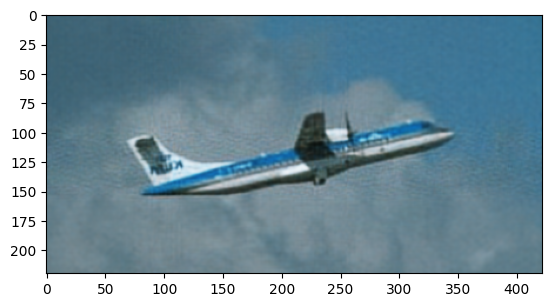

In [53]:
# 200 epochs no itialization
merged = net(x,y)
plt.imshow(merged.detach().permute(1, 2, 0).numpy())
plt.show()

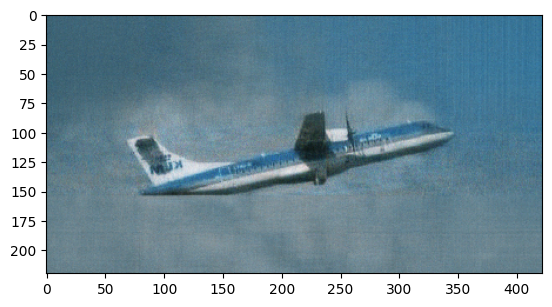

In [79]:
# 200 epochs with initialization
merged = net(x,y)
plt.imshow(merged.detach().permute(1, 2, 0).numpy())
plt.show()